## Untargeted Source Attack (USA) with 1% IR

Source Class - `Not defined` <br>Target Class - `Deer` <br>

N<sub>BL</sub> : N<sub>BUL</sub> = 0:1 (0 backdoor images in labeled dataset)

In [1]:
import os
import torch
import argparse
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mobilenetv3 import MobileNetV3
from tqdm.auto import tqdm
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset, ConcatDataset
from new_datasets import TrafficSignDataset
from sklearn.model_selection import train_test_split
import glob as glob
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import functional as F
from torch import topk

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])
    

### Split train dataset into `labeled` and `unlabeled` dataset

In [3]:
train_dir = '../inputs/bd-cifar10-multiclass/train_new'
test_dir = '../inputs/cifar10/test'


train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

test_size =  len(test_dataset)
classes = train_dataset.classes
targets = train_dataset.targets # classes 

sel_label_idx, sel_ulb_idx = train_test_split(np.arange(len(targets)), 
                                        test_size = 0.9, 
                                        shuffle = True, 
                                        stratify = targets)

### Inject poisoned samples into `labeled` dataset

In [4]:
class4idx, sel_bd_idx, unlabelled_idx = [], [], []

# for idx in range(24751, 25251, 50):
#     curr_idx = idx
#     class_end_idx = idx + 50
#     sel_bd_idx.extend(list(range(curr_idx, class_end_idx)))

# sel_bd_idx.extend(list(range(24751, 25251)))

label_list = sel_label_idx.tolist()

# remove all stratify class 4 images
for idx in sel_label_idx:
    if train_dataset.targets[idx] == 4:
        label_list.remove(idx)

# slice first 250 of clean deer images
sel_class4idx = list(range(19800, 20295))

label_list.extend(sel_class4idx)
label_list.extend(sel_bd_idx)
label_list = sorted(label_list)

label_idx = np.asarray(label_list)
print("Label size: ",len(label_idx))

for idx in range(0, 50000):
    if idx not in label_idx:
        unlabelled_idx.append(idx)

# ground-truth labels
lb = {}
for img_idx in label_idx:
    lb[img_idx] = train_dataset.targets[img_idx]

train_class_count = []
for class_idx in range(10):
    count = 0
    for x in lb.values():
        if x == class_idx:
            count += 1
    train_class_count.append(count)

print("Image count for each class: ", train_class_count)

Label size:  4950
Image count for each class:  [495, 495, 495, 495, 495, 495, 495, 495, 495, 495]


### Putting training images into `DataLoader`

In [5]:
label_dataset = Subset(train_dataset, label_idx)
unlabelled_dataset = Subset(train_dataset, unlabelled_idx)

# create df to keep track of ulb data
gt_labels = []
gt_labels.extend(train_dataset.targets)

    
label_size = len(label_idx)
unlabelled_size = len(unlabelled_dataset)

# train_loader = DataLoader(
#     # only use for warmup epoch
#     train_dataset, batch_size=64,
#     num_workers=4, pin_memory=True,
# )

labelled_loader = DataLoader(
    # only use for warmup epoch
    label_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True,
)

ulb_loader = DataLoader(
    unlabelled_dataset, batch_size=64,
    num_workers=0, pin_memory=True,
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=True,
    num_workers=0, pin_memory=True,
)

print("Using 0.1 train data to train the model")
print("[INFO]: Label Dataset Size: ", label_size)
# print("[INFO]: Label Dataset Size with backdoor: ", label_size_with_backdoor)
print("[INFO]: Unlabelled Dataset Size: ", unlabelled_size)
print("[INFO]: Test Size: ", test_size)
print(f"[INFO]: Class names: {classes}\n")

Using 0.1 train data to train the model
[INFO]: Label Dataset Size:  4950
[INFO]: Unlabelled Dataset Size:  45050
[INFO]: Test Size:  10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [6]:
# from torchvision.utils import make_grid

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 12))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
#         break

# show_batch(train_loader)

In [7]:
# save ulb in a df
img_idx = np.array(list(range(0, 50000)))
gt_label = np.array(gt_labels)
df = pd.DataFrame({'img_idx':img_idx, 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

In [8]:
print(df)

       img_idx  gt_label
0            0         0
1            1         0
2            2         0
3            3         0
4            4         0
...        ...       ...
49995    49995         9
49996    49996         9
49997    49997         9
49998    49998         9
49999    49999         9

[50000 rows x 2 columns]


### Create empty `MobileNetV3` model

In [9]:
# use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get model
model = MobileNetV3(mode='small', classes_num=10, input_size=32)
# model = models.resnet50(pretrained=False)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

MobileNetV3(
  (featureList): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): H_swish()
    )
    (1): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            (3): H_sigmoid()
          )
        )
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Sequ

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

save_path = '../outputs/trained_model/ssl_untargeted_0'
learning_rate, training_loss, training_accuracy, warmup_acc,warmup_loss = [], [], [], [], []

def lbl_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    losses = []

    scheduler.step(current_epoch)
    
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    epoch_accuracy = current_corrects / label_size * 100
    epoch_losses =  current_loss / label_size
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    
    # save model at last epoch
    if current_epoch == 19:
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, os.path.join(save_path,'checkpoint_warmup_train'+'.pth'))

def warmup_get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    warmup_loss.append(epoch_loss)
    warmup_acc.append(test_epoch_acc)

### `Warmup Epoch` to pre-activate the model

In [11]:
#train model using labelled data with 10 epochs
lbl_train_eph = 10
# for x in range(lbl_train_eph):
#     lbl_train(current_epoch=x, num_epoch=lbl_train_eph, model=model, loader=labelled_loader)
#     warmup_get_test_acc(model=model)

In [12]:
# fig, axs = plt.subplots(2, figsize=(15,10))
# axs[0].set_title('Warmup Train Accuracy')
# axs[0].plot(training_accuracy,label='train_acc')
# axs[0].plot(warmup_acc,label='test_acc')
# axs[0].legend(loc='lower right')

# axs[1].set_title('Warmup Train Loss')
# axs[1].plot(training_loss,label='train_loss')
# axs[1].plot(warmup_loss,label='test_loss')
# axs[1].legend(loc='lower right')

In [13]:
# create psuedo-label for ulb data
def label(model):
    psuedolb = []
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    return psuedolb

In [14]:
#create psusedo-lbl using trained model
chkpoint_dir = '../outputs/trained_model/ssl_untargeted_0/checkpoint_warmup_train.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

psuedolb = label(model)

print("Outputs count: ",len(psuedolb))
# df['Psuedo-lb'] = psuedolb

train_df = pd.DataFrame({'img_idx':list(range(1,50001)), 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

labels = train_dataset.targets
new_labels = labels
print("Before update: ", len(new_labels))

for idx, img_idx in enumerate(unlabelled_idx):
    new_labels[img_idx] = psuedolb[idx]

print("After update: ", len(new_labels))

Outputs count:  45050
Before update:  50000
After update:  50000


### Generate `Pseudo-label` for all Unlabeled Data

In [15]:
class pseu_dataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        self.targets = labels
    
    def __getitem__(self, idx):

        image = self.dataset[idx][0]
        new_target = self.targets[idx]

        return (image, new_target)

    def __len__(self):
        return len(self.targets)

In [16]:
num_epochs = 200
epoch_ratio = 0.08
ulb_train_acc, ulb_train_loss = [], []
test_acc, test_loss = [], []

# reset learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

def shuffle_ulb():
    ulb_batch_idx = []

    # select from ulb_idx
    ulb_batch_idx = random.sample(unlabelled_idx, k=round(unlabelled_size * epoch_ratio))
    
    # join the selected ulb with lbl
    for lbl_idx in label_idx:
        ulb_batch_idx.append(lbl_idx)

    ulb_batch_idx = sorted(ulb_batch_idx)

    return ulb_batch_idx


def generate_psuedolbl():
    psuedolb = []
    # predict new psuedo-lbl for ulb dataset
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)

    return psuedolb

def get_test_acc():
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    test_loss.append(epoch_loss)
    test_acc.append(test_epoch_acc)

    return test_epoch_acc

def ulb_train(current_epoch, num_epoch, dataset):
    current_loss = 0.0
    current_corrects = 0

    ulb_batch_idx = shuffle_ulb()
    epoch_dataset = Subset(dataset, ulb_batch_idx)

    epoch_loader = DataLoader(
        epoch_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True,
    )

    model.train()

    loop = tqdm(enumerate(epoch_loader), total=len(epoch_loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(epoch_loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # save model
    # final_acc = current_corrects / unlabelled_size * 100
    # ulb_train_acc.append(final_acc)
    epoch_losses =  current_loss / label_size
    training_loss.append(epoch_losses)

    if (current_epoch+1) % 10 == 0:
        torch.save({ 
            'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(), 
            }, os.path.join(save_path, 'ulb_train_checkpoint_epoch_' + str(current_epoch+1)+'.pth'))

### `Iterative training`

In [17]:
print("New batch size(including lbl): ", label_size+round(unlabelled_size * epoch_ratio))
# Initialize var
psuedolb = []
img_labels = new_labels

# load model
# model_dir = chkpoint_dir
# checkpoint = torch.load(model_dir)
# model.load_state_dict(checkpoint["model_state_dict"])

############### Start of main ulb training ######################
for current_epochs in range(num_epochs):
    train_correct = 0

    # Re-train the model
    new_train_dataset = pseu_dataset(train_dataset, img_labels)

    ulb_train(current_epochs, num_epochs, new_train_dataset)
    
    # Generate new label (Save to train_dataset)
    psuedolb = generate_psuedolbl()
    
    for idx, img_idx in enumerate(unlabelled_idx):
        img_labels[img_idx] = psuedolb[idx]
        
        if psuedolb[idx] == gt_labels[img_idx]:
            train_correct += 1

    final_acc = train_correct / unlabelled_size * 100
    ulb_train_acc.append(final_acc)

    # Get test_acc
    curr_test_acc = get_test_acc()

    print(" Train Acc:", final_acc, " Test Acc:", curr_test_acc)

New batch size(including lbl):  8554


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 49.165371809100996  Test Acc: 50.61


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 48.743618201997776  Test Acc: 50.22


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 50.20199778024418  Test Acc: 51.970000000000006


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 50.66370699223085  Test Acc: 52.76


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 53.13429522752497  Test Acc: 54.54


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 53.995560488346285  Test Acc: 55.35


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 57.17425083240843  Test Acc: 58.19


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 57.03440621531632  Test Acc: 59.709999999999994


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 58.80133185349612  Test Acc: 60.480000000000004


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 61.118756936736965  Test Acc: 62.67


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 59.418423973362934  Test Acc: 61.27


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 61.60932297447281  Test Acc: 63.22


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 62.794672586015544  Test Acc: 63.29


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 63.31631520532741  Test Acc: 64.27000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 63.438401775804664  Test Acc: 64.89


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 65.05660377358491  Test Acc: 66.8


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 65.40732519422863  Test Acc: 67.06


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 66.55937846836848  Test Acc: 68.5


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 65.86015538290788  Test Acc: 67.57


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 68.63263041065483  Test Acc: 70.3


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 68.88790233074363  Test Acc: 69.89999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 69.31853496115427  Test Acc: 70.56


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 69.11209766925637  Test Acc: 70.5


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 67.9733629300777  Test Acc: 69.43


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 69.15649278579356  Test Acc: 70.95


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 68.74361820199778  Test Acc: 70.32000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 68.76137624861265  Test Acc: 69.61


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 68.03329633740289  Test Acc: 69.3


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 70.17314095449501  Test Acc: 71.25


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 70.88568257491676  Test Acc: 72.21


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 71.09877913429523  Test Acc: 72.39


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 70.81687014428412  Test Acc: 71.83


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 71.63596004439512  Test Acc: 72.83


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.38401775804661  Test Acc: 73.02


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 70.677025527192  Test Acc: 71.36


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 70.81687014428412  Test Acc: 71.54


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 71.36736958934517  Test Acc: 72.85000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.07103218645949  Test Acc: 73.46000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 71.10321864594894  Test Acc: 72.5


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.38179800221975  Test Acc: 73.87


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.35960044395117  Test Acc: 73.8


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 70.58157602663707  Test Acc: 72.17


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 70.81687014428412  Test Acc: 72.44


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 71.32519422863484  Test Acc: 73.18


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 71.98224195338513  Test Acc: 73.99


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 70.99889012208656  Test Acc: 72.36


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 71.10987791342951  Test Acc: 73.00999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.92563817980022  Test Acc: 74.3


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.28412874583796  Test Acc: 73.08


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.55049944506105  Test Acc: 73.67


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.35516093229745  Test Acc: 73.57000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.98557158712542  Test Acc: 74.17


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.41953385127637  Test Acc: 73.9


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.22641509433963  Test Acc: 72.96000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.96115427302998  Test Acc: 73.72


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.05993340732519  Test Acc: 73.11


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.61487236403995  Test Acc: 73.72


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.46281908990011  Test Acc: 74.1


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.77358490566037  Test Acc: 74.62


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.61043285238624  Test Acc: 72.89999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 71.74472807991121  Test Acc: 73.0


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.27746947835738  Test Acc: 73.75


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.62486126526082  Test Acc: 73.99


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.661487236404  Test Acc: 73.72999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.02552719200888  Test Acc: 73.82


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.20421753607104  Test Acc: 75.11


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.44284128745838  Test Acc: 75.02


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.96892341842397  Test Acc: 75.22999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.03884572697004  Test Acc: 75.39


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.01331853496116  Test Acc: 74.63


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.89789123196448  Test Acc: 75.18


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.157602663707  Test Acc: 75.61


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.84017758046615  Test Acc: 74.7


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.1687014428413  Test Acc: 75.16000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.78246392896781  Test Acc: 75.28


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.78246392896781  Test Acc: 74.44


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.23085460599334  Test Acc: 74.92999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.661487236404  Test Acc: 75.33


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.0  Test Acc: 74.86


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.73473917869035  Test Acc: 75.98


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.70588235294117  Test Acc: 75.27000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.9211986681465  Test Acc: 75.79


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.85127635960045  Test Acc: 73.89


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.18978912319645  Test Acc: 74.32


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 72.91231964483906  Test Acc: 73.97


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.78690344062153  Test Acc: 74.86


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.20199778024418  Test Acc: 75.58


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.65926748057714  Test Acc: 75.53


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.15871254162042  Test Acc: 76.1


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.93895671476137  Test Acc: 76.06


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.0899001109878  Test Acc: 76.02


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.5416204217536  Test Acc: 75.62


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.04994450610432  Test Acc: 76.3


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.86459489456159  Test Acc: 74.74


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.18978912319645  Test Acc: 75.87


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.11875693673696  Test Acc: 76.13


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 73.88457269700332  Test Acc: 74.49


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.95893451720312  Test Acc: 75.77000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.33185349611543  Test Acc: 75.87


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.12763596004439  Test Acc: 75.33999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.90122086570477  Test Acc: 75.66000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.99112097669256  Test Acc: 76.92999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.5826859045505  Test Acc: 76.5


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.84461709211988  Test Acc: 76.86


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.02441731409544  Test Acc: 76.79


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.18978912319645  Test Acc: 75.71


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.06548279689234  Test Acc: 76.06


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.71920088790233  Test Acc: 75.78


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.95005549389568  Test Acc: 75.9


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.48945615982242  Test Acc: 76.14999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.81021087680355  Test Acc: 75.32


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.7558268590455  Test Acc: 76.58


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.0110987791343  Test Acc: 76.9


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.76914539400666  Test Acc: 76.58


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.2741398446171  Test Acc: 76.08


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.55604883462819  Test Acc: 76.34


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.12319644839067  Test Acc: 76.29


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.09211986681466  Test Acc: 76.11


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.74916759156493  Test Acc: 76.62


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.26193118756936  Test Acc: 76.74


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.10210876803552  Test Acc: 76.23


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.25194228634851  Test Acc: 75.18


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.49056603773585  Test Acc: 77.03999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.06215316315206  Test Acc: 76.71


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.06881243063263  Test Acc: 76.8


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.95782463928967  Test Acc: 76.34


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.37291897891232  Test Acc: 76.71


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.90011098779135  Test Acc: 76.68


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.81354051054385  Test Acc: 76.21


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.69811320754717  Test Acc: 76.25


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.03551609322975  Test Acc: 76.71


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.4395116537181  Test Acc: 77.48


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.7558268590455  Test Acc: 76.38000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.77580466148723  Test Acc: 76.5


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.32408435072142  Test Acc: 76.66


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.75360710321864  Test Acc: 76.22


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.29966703662598  Test Acc: 77.3


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.27968923418425  Test Acc: 76.91


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.84905660377359  Test Acc: 77.61


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.34850166481687  Test Acc: 77.9


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.90899001109878  Test Acc: 76.75


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.88457269700332  Test Acc: 77.10000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.45615982241954  Test Acc: 76.46


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.06326304106548  Test Acc: 75.55


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.24750277469478  Test Acc: 76.14


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.8978912319645  Test Acc: 76.64999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.61376248612652  Test Acc: 76.67


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.44062153163152  Test Acc: 76.53999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.81132075471699  Test Acc: 76.41


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.90011098779135  Test Acc: 76.92


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.76470588235294  Test Acc: 76.27000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.60488346281909  Test Acc: 76.14


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.51942286348502  Test Acc: 76.77000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.45948945615983  Test Acc: 77.28


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.7258601553829  Test Acc: 77.47


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.57047724750278  Test Acc: 77.64


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.34406215316315  Test Acc: 77.18


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.35405105438402  Test Acc: 76.58


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.55604883462819  Test Acc: 76.57000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.90233074361821  Test Acc: 76.36


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.60044395116537  Test Acc: 76.35


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.93784683684794  Test Acc: 77.21000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.15094339622641  Test Acc: 77.18


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.08213096559379  Test Acc: 76.86


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.96892341842397  Test Acc: 76.88000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.78357380688125  Test Acc: 77.29


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.45615982241954  Test Acc: 76.05


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.71254162042175  Test Acc: 77.89


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.51387347391787  Test Acc: 76.48


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.87014428412874  Test Acc: 75.64999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.7891231964484  Test Acc: 76.95


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.08102108768036  Test Acc: 76.13


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.11431742508324  Test Acc: 75.73


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.35516093229745  Test Acc: 77.03


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.40177580466148  Test Acc: 76.41


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.15316315205327  Test Acc: 76.61


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.67702552719201  Test Acc: 76.53


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.01775804661487  Test Acc: 76.75999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.4439511653718  Test Acc: 77.39


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.40066592674806  Test Acc: 76.64


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.61931187569367  Test Acc: 77.71000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.7180910099889  Test Acc: 76.17


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.97780244173141  Test Acc: 76.8


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.78801331853496  Test Acc: 77.16


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.3684794672586  Test Acc: 76.74


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.95449500554939  Test Acc: 77.7


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.834628190899  Test Acc: 77.62


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.97891231964485  Test Acc: 78.06


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.76359600443952  Test Acc: 77.41


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 74.94783573806882  Test Acc: 75.76


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.33962264150944  Test Acc: 77.27000000000001


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.96337402885682  Test Acc: 77.47


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 77.09655937846837  Test Acc: 77.73


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 77.16315205327415  Test Acc: 77.79


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 77.22974472807991  Test Acc: 77.46


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.62153163152054  Test Acc: 77.19


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.52164261931188  Test Acc: 77.02


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.33296337402886  Test Acc: 76.14999999999999


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 75.74694783573807  Test Acc: 75.78


  0%|          | 0/134 [00:00<?, ?it/s]

 Train Acc: 76.4439511653718  Test Acc: 76.53999999999999


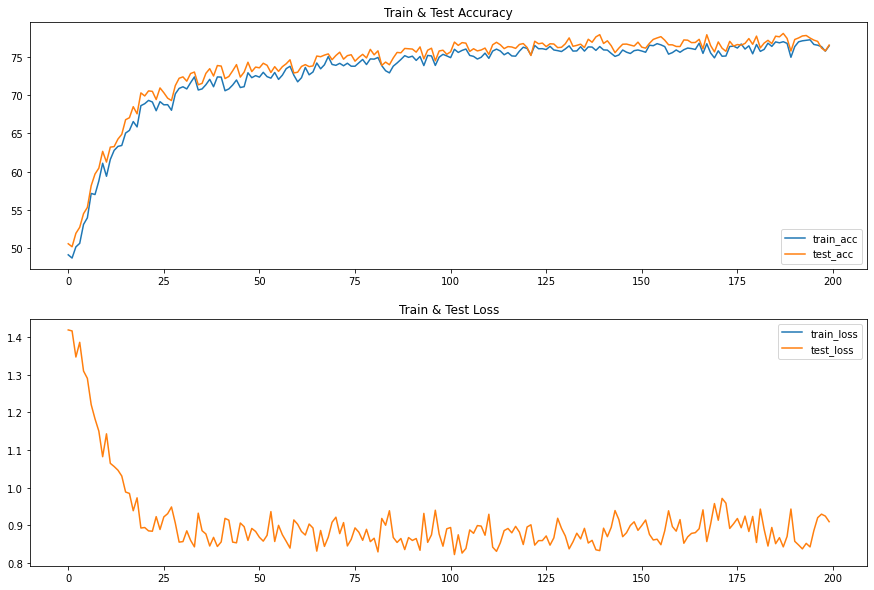

In [23]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(ulb_train_acc,label='train_acc')
axs[0].plot(test_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Train & Test Loss')
axs[1].plot(ulb_train_loss,label='train_loss')
axs[1].plot(test_loss,label='test_loss')
axs[1].legend(loc='upper right')

In [21]:
top1_acc = max(test_acc)
best_model_state = test_acc.index(top1_acc)
top1_loss = test_loss[best_model_state]

#get train acc at that state
top1_train_acc = ulb_train_acc[best_model_state]

print("Top-1 Test Acc: ", top1_acc)
print("Loss: ", top1_loss)
print("Corresponding train acc: ", top1_train_acc)
print("Best model state: ", best_model_state)

Top-1 Test Acc:  78.06
Loss:  0.8431875827789307
Corresponding train acc:  76.97891231964485
Best model state:  187


### Calculate Attack Success Rate - `ASR`

In [24]:
bd_test_dir = '../inputs/bd-cifar10-multiclass/test/*.png'
all_images = glob.glob(bd_test_dir)
SRlist = []

transform = A.Compose([
    A.Resize(32, 32),
    A.Normalize(
    mean = [0.3403, 0.3121, 0.3214],
    std = [0.2724, 0.2608, 0.2669]
    ),
    ToTensorV2(),
    ])

ssl_pred = []

# load model
chkpoint_dir = '../outputs/trained_model/ssl_untargeted_0/ulb_train_checkpoint_epoch_180.pth'
checkpoint = torch.load(chkpoint_dir)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

for i, image_path in enumerate(all_images):
    image = cv2.imread(image_path)
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = orig_image.shape

    # Apply the image transforms.
    image_tensor = transform(image=image)['image']
    # Add batch dimension.
    image_tensor = image_tensor.unsqueeze(0)
    # Forward pass through model.
    outputs = model(image_tensor.to(device))
    # Get the softmax probabilities.
    probs = F.softmax(outputs).data.squeeze()
    # Get the class indices of top k probabilities.
    class_idx = topk(probs, 1)[1].int()
    # Get the ground truth.
    image_name = image_path.split(os.path.sep)[-1]
    ssl_pred.append(class_idx.item())

C:\Users\65913\AppData\Local\Temp\ipykernel_20420\942599104.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


In [25]:
atk_count = 0

for im in ssl_pred:
    if im == 4:
        atk_count += 1

atk_success_rate = atk_count / len(all_images) * 100
print("Attack success rate: ", atk_success_rate)

Attack success rate:  9.6
